In [10]:
invisible(lapply(c(
  "Cairo", "dplyr", "tidyr", "duckdb", "dbplyr", "ggplot2",
  "rnaturalearth", "rnaturalearthdata", "sf"
), library, character.only = TRUE))

custom_palette <- c(
  "#0072B2",  "#D55E00", "#CC79A7", "#009E73", "#E69F00", "#56B4E9",
  "#F0E442", "#999999", "#000000"
)
options(
  repr.plot.width = 6, repr.plot.height = 3.5, repr.plot.res = 300,
  repr.plot.antialias = "subpixel",
  contrasts = c("contr.sum", "contr.poly"),
  ggplot2.discrete.fill = custom_palette,
  ggplot2.discrete.colour = custom_palette
)
theme_set(
  theme_bw() +
    theme(
      text = element_text(family = 'Open Sans'),
      plot.title = element_text(face = "bold", hjust = 0.5),
      legend.position = "top",
      legend.direction = "horizontal",
      legend.box = "vertical",
      panel.grid.major.x = element_blank(),
      panel.grid.minor = element_blank(),
      strip.background = element_blank(),
      axis.title = element_text(size = rel(1.1), face = "bold"),
      axis.text = element_text(size = rel(1.1), face = "bold"),
      strip.text = element_text(size = rel(1.1), face = "bold")
    )
)

In [11]:
con <- dbConnect(
  duckdb(), dbdir = "../processing/amfungi_lsu.duckdb", read_only = FALSE
)
inner_join(
  tbl(con, "occurances") |> select(sample_id, taxon_id, abundance, total),
  tbl(con, "samples") |> select(id, longitude, latitude),
  by = join_by(sample_id == id)
) |>
  inner_join(
    tbl(con, "taxa") |> select(taxa_id, Species),
    by = join_by(taxon_id == taxa_id)
  ) |>
  compute(name = "locations")

# Source:   table<locations> [?? x 7]
# Database: DuckDB v0.9.2 [robert@Linux 6.6.17_1:R 4.3.2/../processing/amfungi_lsu.duckdb]
   sample_id taxon_id abundance  total longitude latitude Species               
   <chr>     <chr>        <int>  <int>     <dbl>    <dbl> <chr>                 
 1 7805      MT832194        12 221538    -116.      43.3 Rhizophagus irregular…
 2 7806      MT832194        41 951993    -116.      43.3 Rhizophagus irregular…
 3 7814      MT832194         2 139418    -116.      43.3 Rhizophagus irregular…
 4 8077      MT832194         5  30383    -116.      43.3 Rhizophagus irregular…
 5 7929      MT832194         2  54553    -116.      43.3 Rhizophagus irregular…
 6 8007      MT832194         1    765    -122.      48.8 Rhizophagus irregular…
 7 7806      MT832194         1 951993    -116.      43.3 Rhizophagus irregular…
 8 7807      MT832194         1  20890     -99.6     24.9 Rhizophagus irregular…
 9 7806      MT832194         1 951993    -116.      43.3 Rhi

Species,n
<chr>,<dbl>
Septoglomus_sp,273
Glomus_sp,305
Diversispora celata,31
Acaulospora spinosa,4
Otospora bareae,661
Dominikia minuta,22
Cetraspora_sp,12
Claroideoglomus candidum,308
Dominikia iranica,33


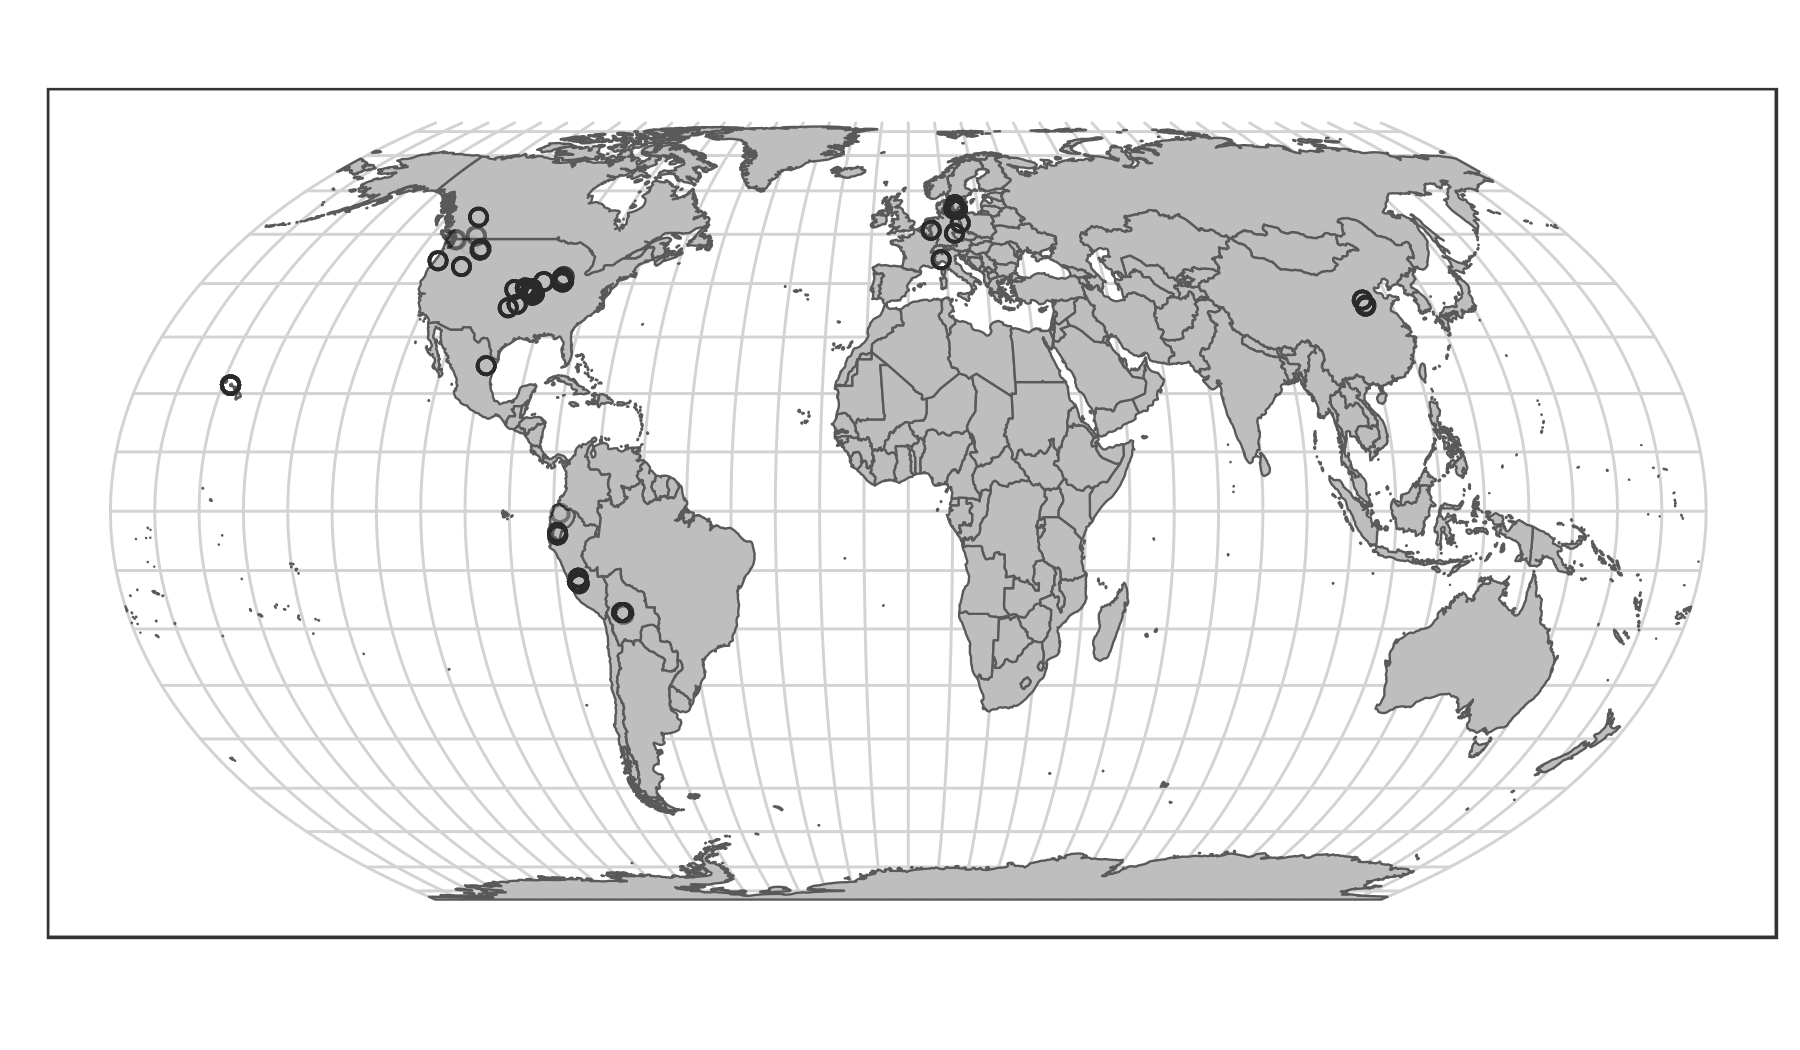

In [13]:
count(tbl(con, "locations"), Species) |> collect()
world <- ne_countries(scale = "medium", returnclass = "sf")
p <- ggplot(
  data = tbl(con, "locations")
) +
  geom_sf(
    data = world, fill = "grey", show.legend = FALSE
  ) +
  geom_point(
    aes(x = longitude, y = latitude),
    shape = 21, color = "black", fill = NA, alpha = 0.01
  ) +
  coord_sf(crs = "WGS84 +proj=eqearth", default_crs = "EPSG:4326") +
  theme(
    panel.grid = element_line(color = "lightgray", size = 0.25),
  ) +
  scale_x_continuous(breaks = seq(-180, 180, 10)) +
  scale_y_continuous(breaks = seq(-90, 90, 10)) +
  labs(
    x = element_blank(), y = element_blank()
  )
suppressWarnings(print(p))

In [9]:
dbDisconnect(con, shutdown = TRUE)